In [ ]:
# Desactivar logging duplicado
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)

# Evitar duplicación de salida en Jupyter
import sys
if hasattr(sys.stdout, '_original_write'):
    sys.stdout.write = sys.stdout._original_write
if hasattr(sys.stderr, '_original_write'):
    sys.stderr.write = sys.stderr._original_write

**Angie Carolina Joya Duarte - 2322609**  

**Sheila Marcela Valencia Chito - 2243011**

# Entrega 2 - RNN

Se escogió para este trabajo el dataset "Twitter US Airline Sentiment"

## Importación y análisis del dataset

Importamos las librerías

In [3]:
# %pip install transformers
#%pip install torch torchvision
# %pip install ipywidgets
# %pip install jupyter
# %pip install protobuf
# %pip install emoji

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
import nltk
import torch

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample, class_weight

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import emoji
from nltk.tokenize import TweetTokenizer

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Definimos las funciones auxiliares para graficar

In [5]:
def graficaDistribucion (dataset, atributo, etiquetas, ejeX, ejeY, titulo):
    graphOutput = sns.countplot(x=atributo, hue=atributo, data=dataset, palette="Set2", legend=False)
    total = len(dataset)

    for p in graphOutput.patches:
        count = p.get_height() #frecuencia absoluta
        percent = 100 * count / total #frecuencia relativa

        graphOutput.annotate(f'{percent:.1f}%', # formato de texto
            (p.get_x() + p.get_width() / 2., count/2),  #posición
            ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
            textcoords='offset points')

    ticks = graphOutput.get_xticks()
    graphOutput.set_xticks(ticks)
    graphOutput.set_xticklabels(etiquetas)
    graphOutput.set_xlabel(ejeX)
    graphOutput.set_ylabel(ejeY)
    graphOutput.set_title(titulo)

    plt.show()

In [6]:
def graficaEntrenamiento(resultado, set1, set2, titulo, ylabel):
    plt.plot(resultado.history[set1], label="Entrenamiento")
    plt.plot(resultado.history[set2], label="Validación")
    plt.title(titulo)
    plt.xlabel("Época")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [7]:
def graficaMatriz(yTest_labels, yPred_labels):
  # Matriz de confusión
  cm = confusion_matrix(yTest_labels, yPred_labels)
  class_names = ['Negativo', 'Neutro', 'Positivo']

  # Graficar
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Matriz de Confusión")

  plt.xlabel("Predicción")
  plt.ylabel("Etiqueta real")

  plt.show()

Importamos el dataset y lo almacenamos como un dataframe de pandas. Verificamos que no hayan datos faltantes y revisamos la distribución porcentual de los datos para verificar si el conjunto sea representativo


In [8]:
path = os.path.join(os.getcwd(), "Tweets.csv")
dataset = pd.read_csv(path, usecols=[1, 5, 10])
dataset.info()
print("\nAerolíneas:", dataset.airline.unique())
print("Opiniones:", dataset.airline_sentiment.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   airline            14640 non-null  object
 2   text               14640 non-null  object
dtypes: object(3)
memory usage: 343.3+ KB

Aerolíneas: ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']
Opiniones: ['neutral' 'positive' 'negative']


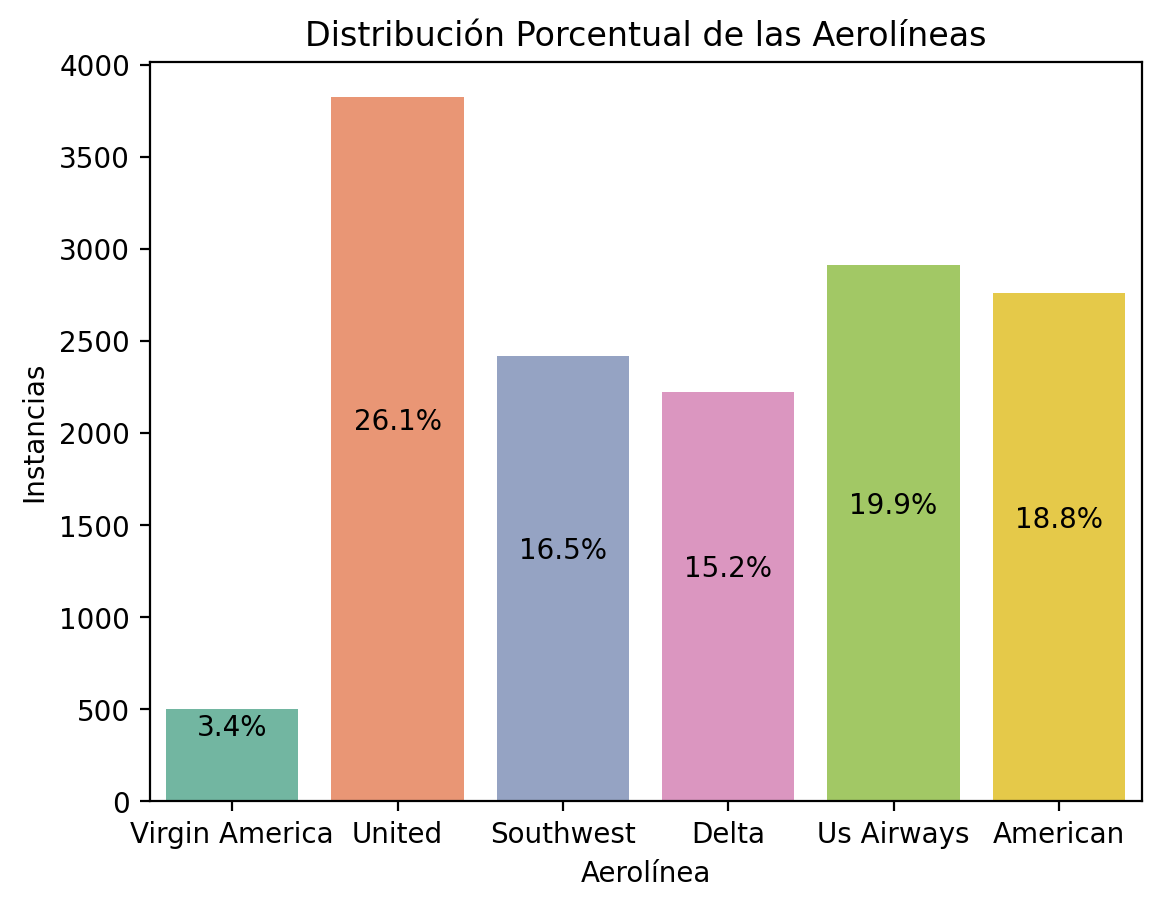

In [9]:
graficaDistribucion(dataset,"airline",["Virgin America", "United", "Southwest", "Delta", "Us Airways", "American"],"Aerolínea","Instancias","Distribución Porcentual de las Aerolíneas")

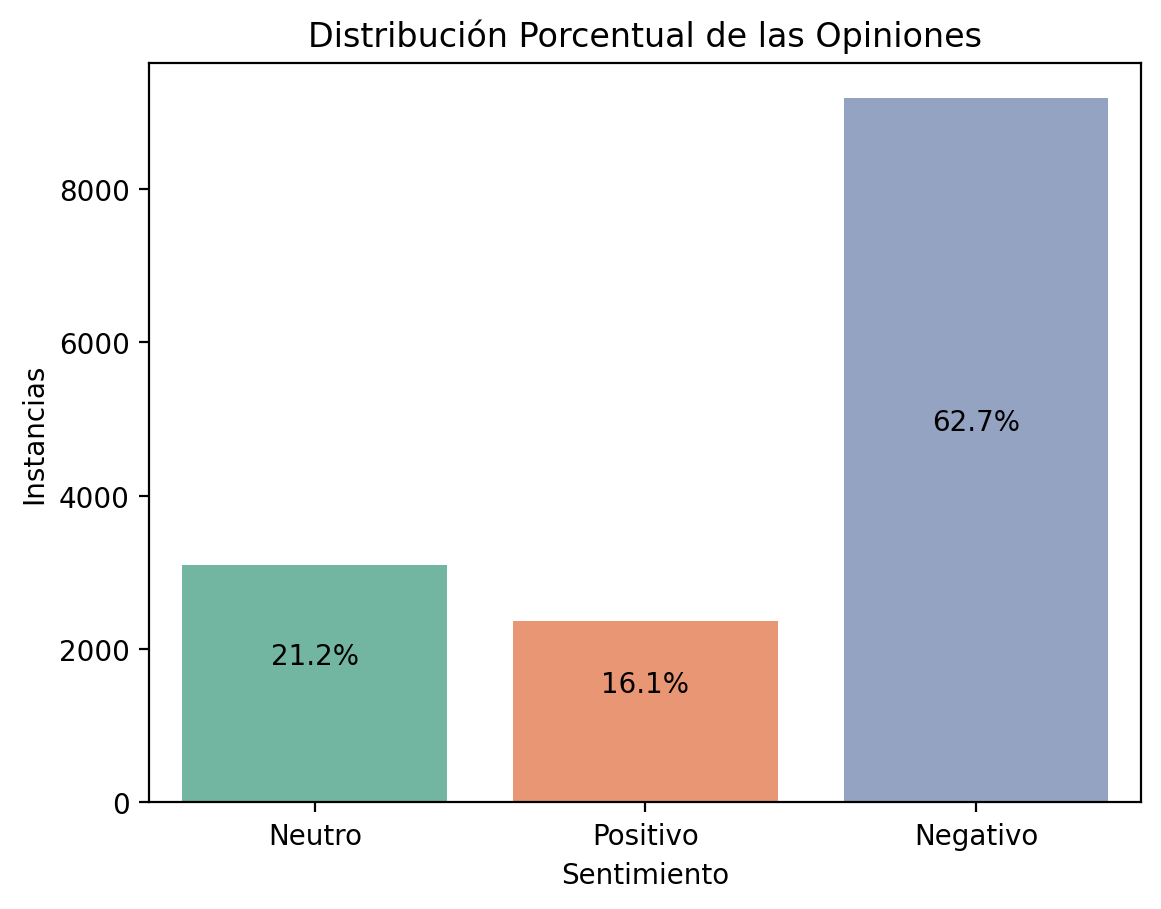

In [10]:
graficaDistribucion(dataset,"airline_sentiment",["Neutro", "Positivo", "Negativo"],"Sentimiento","Instancias","Distribución Porcentual de las Opiniones")

Hay un desbalanceo en las opiniones, la opinión positiva tiene el 62.7% y la negativa tiene el 16.1%, así que se implementarán técnicas de muestreo para balancear los datos.

## Preprocesamiento de los datos

Representamos las opiniones con etiquetas de enteros: 0 para negativa, 1 para neutral y 2 para positiva

In [11]:
dataset = dataset.drop(["airline"], axis=1)
dataset["sentiment"] = dataset["airline_sentiment"].replace({"negative" : 0, "neutral" : 1, "positive" : 2}).astype(int)
dataset = dataset.drop(["airline_sentiment"], axis=1)

C:\Users\USUARIO\AppData\Local\Temp;\ipykernel_1912\2424373769.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["sentiment"] = dataset["airline_sentiment"].replace({"negative" : 0, "neutral" : 1, "positive" : 2}).astype(int)


Procesamos y tokenizamos el texto para poder asignarle representaciones numéricas que se puedan utilizar en la Red Neuronal

La técnica de submuestreo Near Miss Centroids solo funciona cuando los datos a procesar son numéricos. Debido a que tenemos texto en su lugar, implementamos otras técnicas para balancear el dataset. En este caso, Submuestreo Leve y Weighted Loss

In [12]:
#Submuestreo del 70% de la clase mayoritaria (negativo)

instancias = dataset.sentiment.value_counts()
print("Dataset original: ", instancias)

subNegativas = int(instancias[0]*1)

dfNegativo = dataset[dataset.sentiment == 0]
dfOtras = dataset[dataset.sentiment != 0]

submuestreo = resample(
  dfNegativo,
  replace=False,
  n_samples=subNegativas,
  random_state=42
)

datasetBal = pd.concat([submuestreo, dfOtras]).sample(frac=1).reset_index(drop=True)
datasetBal = datasetBal.sample(frac=1, random_state=42).reset_index(drop=True)
print("Dataset con submuestreo: ", datasetBal.sentiment.value_counts())

Dataset original:  sentiment
0    9178
1    3099
2    2363
Name: count, dtype: int64
Dataset con submuestreo:  sentiment
0    9178
1    3099
2    2363
Name: count, dtype: int64


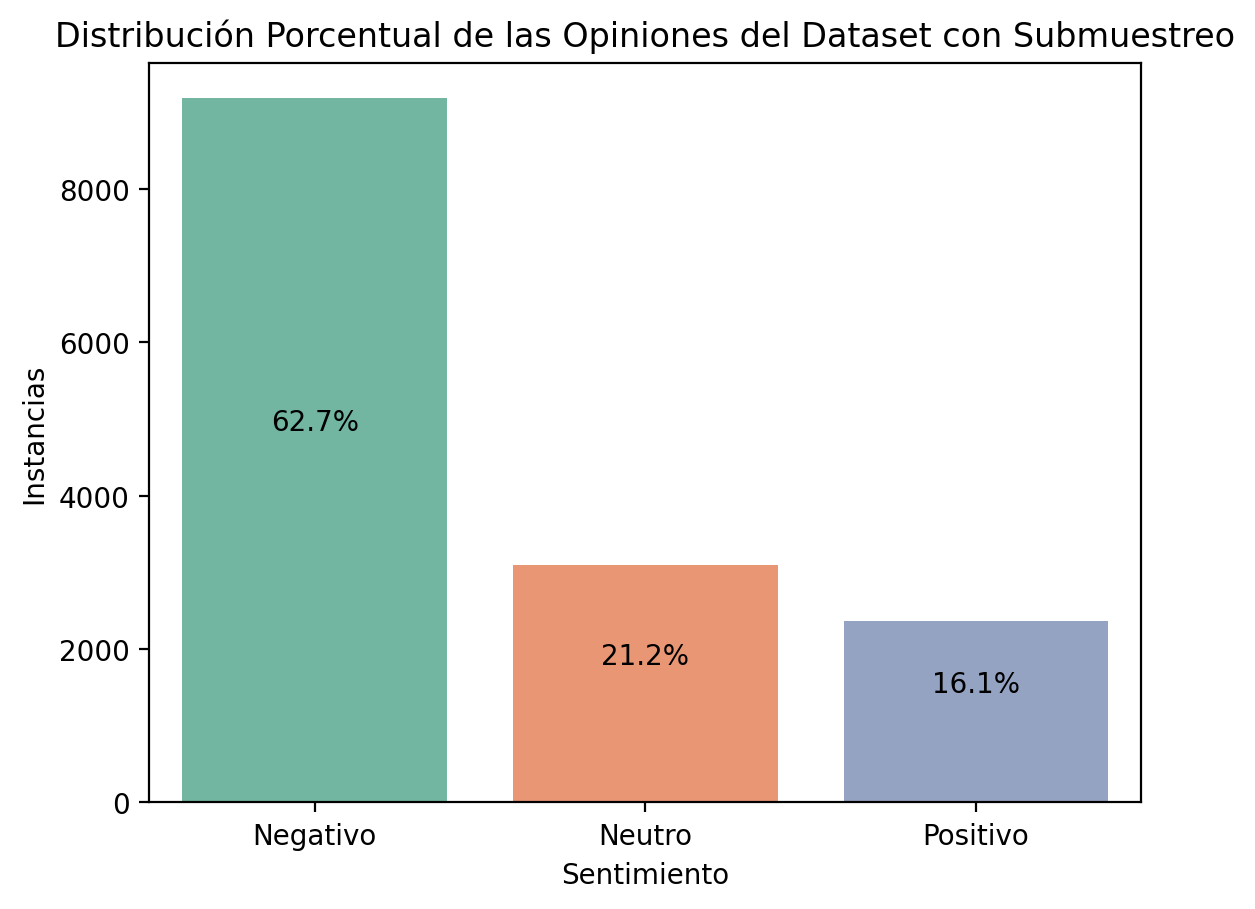

In [13]:
graficaDistribucion(datasetBal,"sentiment",["Negativo", "Neutro", "Positivo"],"Sentimiento","Instancias","Distribución Porcentual de las Opiniones del Dataset con Submuestreo")

El algoritmo TF-IDF no conserva el orden de las palabras, lo que es importante para las Redes Neuronales Recurrentes. Así que se usará el tokenizador de Keras para darle un valor numérico al texto preprocesado

In [14]:
class_weights = class_weight.compute_class_weight(
  class_weight='balanced',
  classes=np.unique(datasetBal["sentiment"]),
  y=datasetBal["sentiment"]
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.5317062540858575), 1: np.float64(1.5747015166182639), 2: np.float64(2.0651713922979265)}


In [15]:
# X = pad_sequences(datasetBal["repTemporal"], maxlen=max(len(seq) for seq in datasetBal["repTemporal"]), padding='post')
# datasetBal["rep"] = list(X)
# datasetBal = datasetBal.drop(columns=["repTemporal"])

# datasetBal.head()

Luego de realizar el submuestreo podemos convertir la salidas en vectores de binarios usando one hot encoding

In [16]:
datasetBal["one_hot"] = list(to_categorical(datasetBal["sentiment"], num_classes=3))

## BERTweet

In [17]:
tokenizerNorm = TweetTokenizer()

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif emoji.is_emoji(token):
        return emoji.demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet):
    tokens = tokenizerNorm.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())


### Descargar el modelo

In [18]:
modelName = "vinai/bertweet-base"

bertweet = AutoModelForSequenceClassification.from_pretrained(modelName, cache_dir="./BERTweet", num_labels=3)

tokenizer = AutoTokenizer.from_pretrained(modelName, cache_dir="./BERTweet", use_fast=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
datasetBal["textNorm"] = datasetBal["text"].map(normalizeTweet)
datasetBal.head()

,text,sentiment,one_hot,textNorm
0,@USAirways we even offered to fly in to anothe...,1,"[0.0, 1.0, 0.0]",@USER we even offered to fly in to another air...
1,@AmericanAir @nrosenb1 it says changes can't b...,0,"[1.0, 0.0, 0.0]",@USER @USER it says changes can't be made online
2,@AmericanAir thank you,2,"[0.0, 0.0, 1.0]",@USER thank you
3,@USAirways @shivadelrahim what about upgrades?,1,"[0.0, 1.0, 0.0]",@USER @USER what about upgrades ?
4,@JetBlue can I change my flight if I already p...,1,"[0.0, 1.0, 0.0]",@USER can I change my flight if I already prin...


In [ ]:
def encode(text):
    return tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=128
    )
    
# Aplica la tokenización y convierte a diccionario
encoded = datasetBal["textNorm"].apply(lambda x: encode(x))

# Crea nuevas columnas en el DataFrame
datasetBal["input_ids"] = encoded.apply(lambda x: x["input_ids"])
datasetBal["attention_mask"] = encoded.apply(lambda x: x["attention_mask"])

datasetBal.head()

,text,sentiment,one_hot,textNorm,input_ids,attention_mask
0,@USAirways we even offered to fly in to anothe...,1,"[0.0, 1.0, 0.0]",@USER we even offered to fly in to another air...,"[0, 5, 54, 132, 4790, 9, 2039, 16, 9, 347, 370...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,@AmericanAir @nrosenb1 it says changes can't b...,0,"[1.0, 0.0, 0.0]",@USER @USER it says changes can't be made online,"[0, 5, 5, 18, 422, 2303, 129, 31, 214, 899, 2,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ..."
2,@AmericanAir thank you,2,"[0.0, 0.0, 1.0]",@USER thank you,"[0, 5, 419, 14, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,@USAirways @shivadelrahim what about upgrades?,1,"[0.0, 1.0, 0.0]",@USER @USER what about upgrades ?,"[0, 5, 5, 66, 62, 29347, 21, 2, 1, 1, 1, 1, 1,...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,@JetBlue can I change my flight if I already p...,1,"[0.0, 1.0, 0.0]",@USER can I change my flight if I already prin...,"[0, 5, 56, 8, 431, 23, 2542, 65, 8, 306, 9603,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [21]:
from torch.utils.data import Dataset, DataLoader
import torch

# Dataset personalizado para PyTorch
class TweetDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels
    
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
    
    def __len__(self):
        return len(self.labels)


### Preparar conjuntos de entrenamiento, validación y prueba

70% para entrenamiento, 15% para validación y 15% para pruebas


In [22]:
n = len(datasetBal)

# Dividir los datos
train_size = int(n * 0.7)
val_size = int(n * 0.85)

# Preparar los datos para cada conjunto
input_ids_list = datasetBal["input_ids"].tolist()
attention_mask_list = datasetBal["attention_mask"].tolist()
labels_list = datasetBal["sentiment"].tolist()

# Train set
train_dataset = TweetDataset(
    input_ids_list[:train_size],
    attention_mask_list[:train_size],
    labels_list[:train_size]
)

# Validation set
val_dataset = TweetDataset(
    input_ids_list[train_size:val_size],
    attention_mask_list[train_size:val_size],
    labels_list[train_size:val_size]
)

# Test set
test_dataset = TweetDataset(
    input_ids_list[val_size:],
    attention_mask_list[val_size:],
    labels_list[val_size:]
)

print(f"Tamaño conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño conjunto de validación: {len(val_dataset)}")
print(f"Tamaño conjunto de prueba: {len(test_dataset)}")


Tamaño conjunto de entrenamiento: 10248
Tamaño conjunto de validación: 2196
Tamaño conjunto de prueba: 2196


### Crear DataLoaders


In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Número de batches de entrenamiento: {len(train_loader)}")
print(f"Número de batches de validación: {len(val_loader)}")
print(f"Número de batches de prueba: {len(test_loader)}")


Número de batches de entrenamiento: 641
Número de batches de validación: 138
Número de batches de prueba: 138


### Configurar el modelo y optimizador


In [ ]:
# Configurar el dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Mover el modelo al dispositivo
bertweet.to(device)

#Congelar las 8/12 primeras capas
for layer_idx in range(8):
    for param in bertweet.roberta.encoder.layer[layer_idx].parameters():
        param.requires_grad = False

# Configurar el optimizador con learning rates diferenciados
# Las capas BERT entrenan más lento, el clasificador más rápido
optimizer = torch.optim.AdamW([
    {'params': bertweet.roberta.encoder.layer[8:].parameters(), 'lr': 2e-5},  # Últimas 4 capas BERT
    {'params': bertweet.classifier.parameters(), 'lr': 5e-5}  # Clasificador
], weight_decay=0.01)

# Calcular class weights para manejar el desbalanceo
from sklearn.utils.class_weight import compute_class_weight

labels_array = np.array(labels_list[:train_size])
classes = np.unique(labels_array)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=labels_array)
class_weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)

print("Class weights:", class_weights_tensor)

# Configurar Learning Rate Scheduler con warmup


from torch.optim.lr_scheduler import LinearLR, SequentialLR
# Función de pérdida con pesosprint(f"Scheduler configurado: {warmup_epochs} épocas de warmup, luego decaimiento lineal")


criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Warmup para las primeras épocas y luego decaimiento
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, decay_scheduler], milestones=[warmup_epochs])

warmup_epochs = 2

total_epochs = 10decay_scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=total_epochs-warmup_epochs)

warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)

Usando dispositivo: cpu
Class weights: tensor([0.5299, 1.5881, 2.0690])


### Función de entrenamiento con BERTweet


In [ ]:
def entrenamientoBERT(model, train_loader, val_loader, test_loader, optimizer, criterion, device, scheduler=None, epochs=3, patience=4):
    """
    Función de entrenamiento para BERTweet con early stopping, gradient clipping y learning rate scheduling
    """
    history = {
        'loss': [],
        'accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Fase de entrenamiento
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        print(f"\nÉpoca {epoch + 1}/{epochs}", flush=True)
        print_every = 50  # Imprimir cada 50 batches
        
        for batch_idx, batch in enumerate(train_loader):
            # Mover datos al dispositivo
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Calcular pérdida
            loss = criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping para evitar explosión de gradientes
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Métricas
            train_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
            
            # Imprimir progreso cada ciertos batches
            if (batch_idx + 1) % print_every == 0:
                current_loss = train_loss / (batch_idx + 1)
                current_acc = train_correct / train_total
                print(f"  Batch {batch_idx + 1}/{len(train_loader)} - Loss: {current_loss:.4f} - Acc: {current_acc:.4f}", flush=True)
        
        # Promedios de entrenamiento
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        
        # Fase de validación
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                
                loss = criterion(logits, labels)
                
                val_loss += loss.item()
                predictions = torch.argmax(logits, dim=1)
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
        
        # Promedios de validación
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        
        # Guardar métricas
        history['loss'].append(avg_train_loss)
        history['accuracy'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        # Actualizar learning rate scheduler
        if scheduler is not None:
            scheduler.step()
            current_lr = optimizer.param_groups[0]['lr']
            print(f"  Learning Rate: {current_lr:.2e}", flush=True)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping activado en época {epoch + 1}", flush=True)
                break
    
    # Restaurar mejor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Modelo restaurado al mejor estado (menor val_loss)", flush=True)
    
    # Evaluación final en test
    model.eval()
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            predictions = torch.argmax(logits, dim=1)
            test_correct += (predictions == labels).sum().item()
            test_total += labels.size(0)

    
    print(f"\nAccuracy de pruebas: {test_accuracy:.4f}", flush=True)

    test_accuracy = test_correct / test_total
        return history

    print(f"\nAccuracy de pruebas: {test_accuracy:.4f}", flush=True)
    return history
    

### Entrenar el modelo BERTweet


In [ ]:
epocas = 10

resultadoBERT = entrenamientoBERT(
    bertweet, 
    train_loader, 
    val_loader, 
    test_loader, 
    optimizer, 
    criterion, 
    device,
    scheduler=scheduler,  # Añadir scheduler
    epochs=epocas, 
    patience=4
)

# Mostrar resultados de primera y última época
resultados = {
    "Época": ["Primera", "Última"],
    "Loss": [resultadoBERT['loss'][0], resultadoBERT['loss'][-1]],
    "Val_Loss": [resultadoBERT['val_loss'][0], resultadoBERT['val_loss'][-1]],
    "Accuracy": [resultadoBERT['accuracy'][0], resultadoBERT['accuracy'][-1]],
    "Val_Accuracy": [resultadoBERT['val_accuracy'][0], resultadoBERT['val_accuracy'][-1]],
}

tabla = pd.DataFrame(resultados)
print("\n", tabla)



Época 1/5
  Batch 50/641 - Loss: 1.0701 - Acc: 0.5825
  Batch 50/641 - Loss: 1.0701 - Acc: 0.5825
  Batch 100/641 - Loss: 1.0652 - Acc: 0.5531
  Batch 100/641 - Loss: 1.0652 - Acc: 0.5531
  Batch 150/641 - Loss: 1.0611 - Acc: 0.5533
  Batch 150/641 - Loss: 1.0611 - Acc: 0.5533
  Batch 200/641 - Loss: 1.0531 - Acc: 0.5722
  Batch 200/641 - Loss: 1.0531 - Acc: 0.5722
  Batch 250/641 - Loss: 1.0447 - Acc: 0.5880
  Batch 250/641 - Loss: 1.0447 - Acc: 0.5880
  Batch 300/641 - Loss: 1.0383 - Acc: 0.5923
  Batch 300/641 - Loss: 1.0383 - Acc: 0.5923
  Batch 350/641 - Loss: 1.0344 - Acc: 0.5934
  Batch 350/641 - Loss: 1.0344 - Acc: 0.5934
  Batch 400/641 - Loss: 1.0297 - Acc: 0.6027
  Batch 400/641 - Loss: 1.0297 - Acc: 0.6027
  Batch 450/641 - Loss: 1.0238 - Acc: 0.6099
  Batch 450/641 - Loss: 1.0238 - Acc: 0.6099
  Batch 500/641 - Loss: 1.0190 - Acc: 0.6144
  Batch 500/641 - Loss: 1.0190 - Acc: 0.6144
  Batch 550/641 - Loss: 1.0122 - Acc: 0.6220
  Batch 550/641 - Loss: 1.0122 - Acc: 0.6220
 

### Continuar entrenamiento (5 épocas adicionales)

### Predicciones y Matriz de Confusión


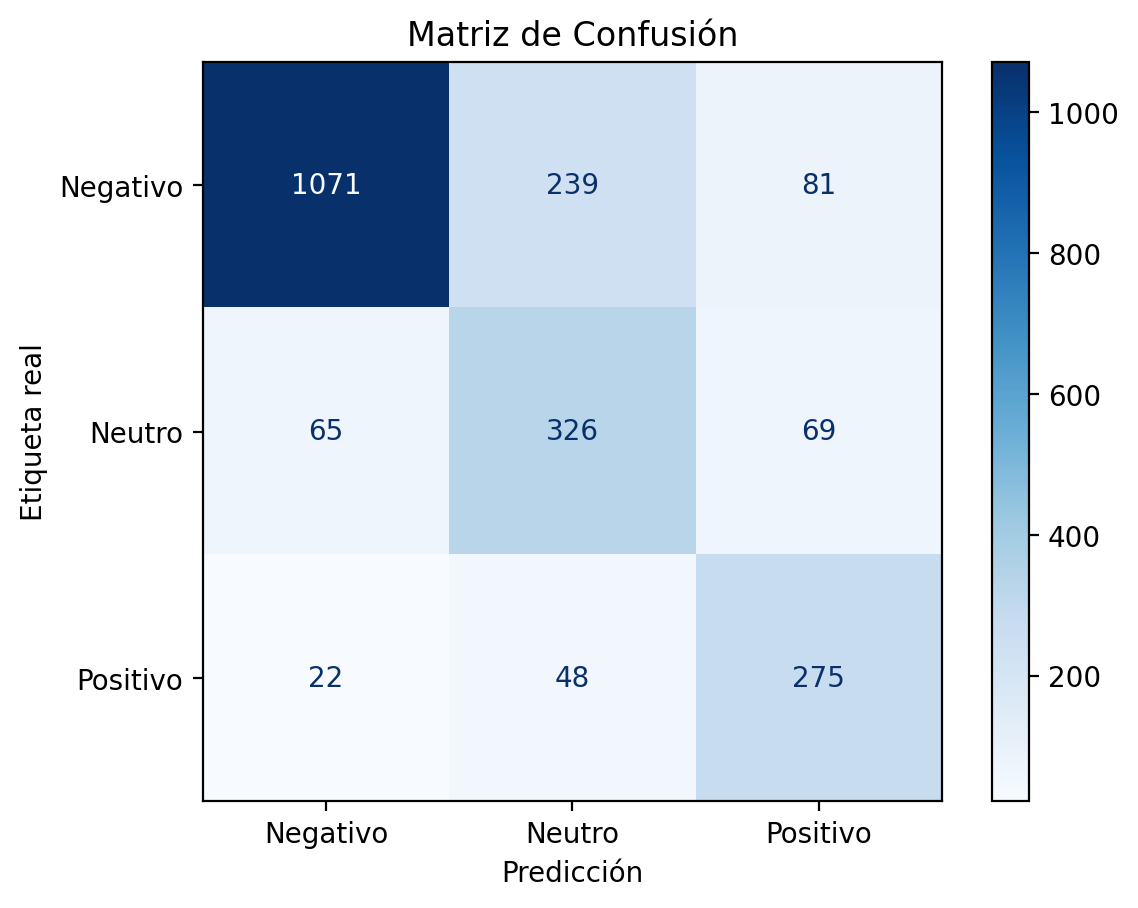

In [38]:
# Obtener predicciones en el conjunto de prueba
bertweet.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = bertweet(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        predictions = torch.argmax(logits, dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convertir a arrays de numpy
yPred_labels = np.array(all_predictions)
yTest_labels = np.array(all_labels)

# Graficar matriz de confusión
graficaMatriz(yTest_labels, yPred_labels)


### Gráficas de evolución del entrenamiento


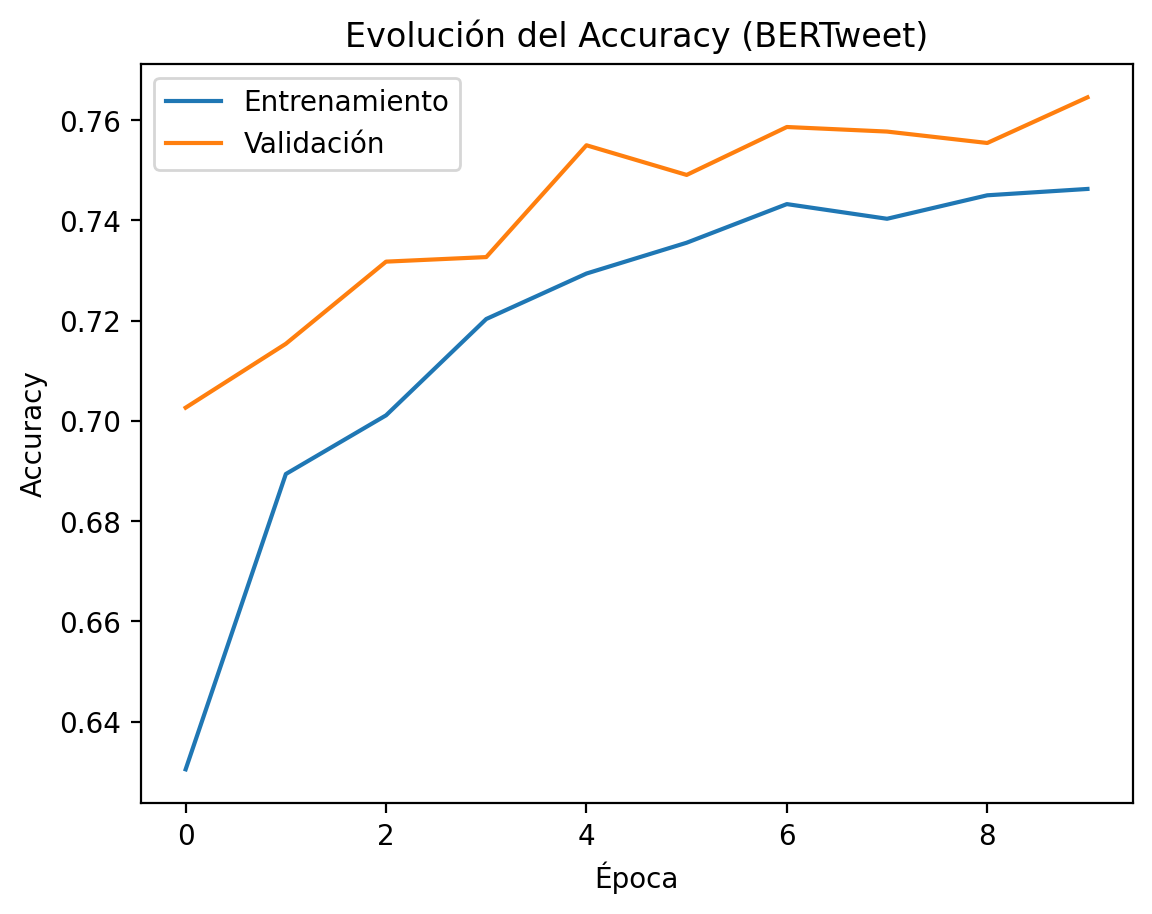

In [ ]:
# Adaptar la función de graficado para usar el historial de BERTweet
class HistoryWrapper:
    """Wrapper para hacer que el historial de BERTweet sea compatible con la función graficaEntrenamiento"""
    def __init__(self, history_dict):
        self.history = history_dict

resultado_wrapper = HistoryWrapper(resultadoBERT)

# Graficar evolución del accuracy
graficaEntrenamiento(resultado_wrapper, "accuracy", "val_accuracy", "Evolución del Accuracy (BERTweet)", "Accuracy")


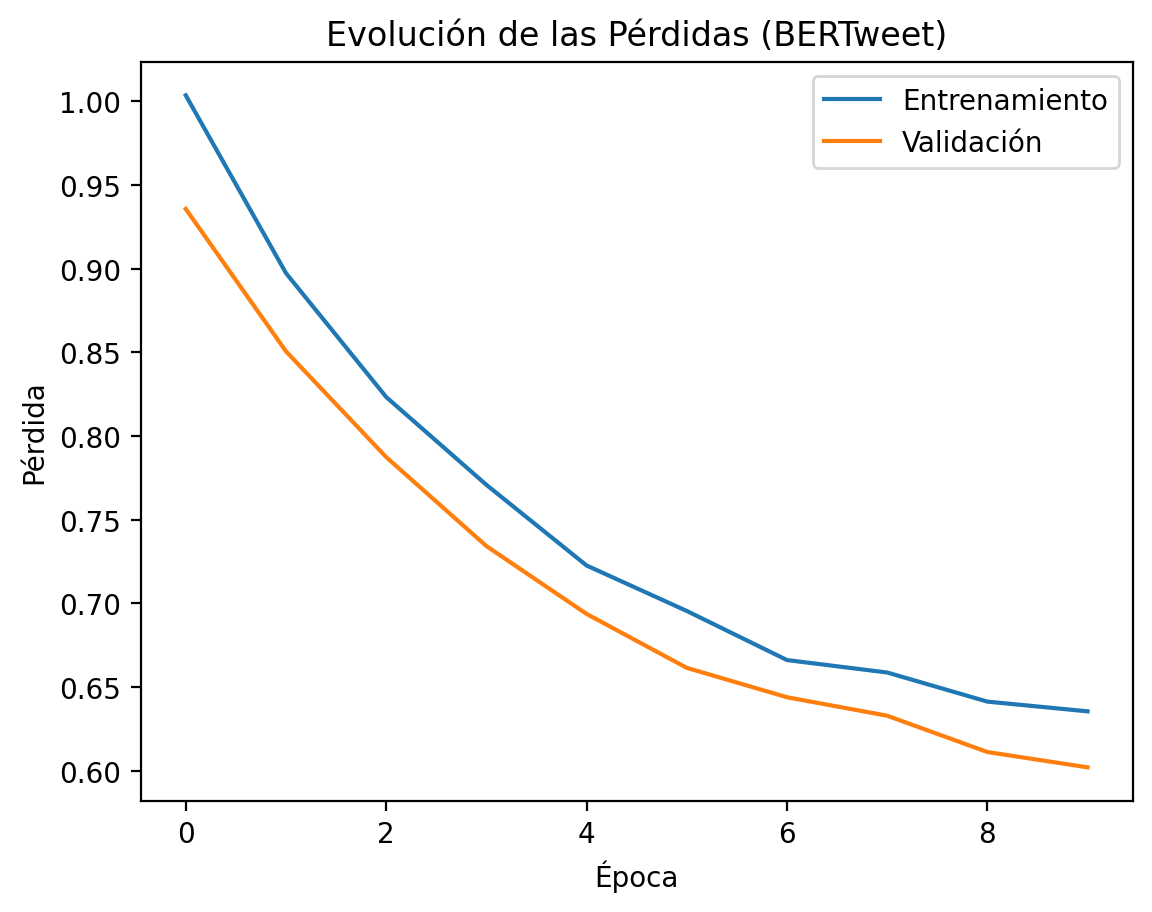

In [40]:
# Graficar evolución de las pérdidas
graficaEntrenamiento(resultado_wrapper, "loss", "val_loss", "Evolución de las Pérdidas (BERTweet)", "Pérdida")
